# （1）猫狗大战

## 1．下载并整理图像
步骤 1 访问 https://www.kaggle.com/c/dogs-vs-cats，在打开的网页中单击“Data”→“Download All”按钮，下载图像压缩包。  
步骤 2 解压下载的文件“dogs-vs-cats.zip”，将“train.zip”和“test1.zip”解压到 Jupyter Notebook的工作目录下。  
步骤 3 为方便建立图像标签，在文件夹“train”中建立两个子文件夹，分别命名为“cat”和“dog”，并将文件夹“train”中文件名以“cat”开头的图像文件移动到文件夹“cat”中，将文件名以“dog”开头的图像文件移动到文件夹“dog”中。  
## 2．构建数据集
步骤 1 导入本项目所用到模块与包。  
步骤 2 定义数据读取函数，函数参数为指定文件夹。① 读取指定文件夹下的图像文件信息；② 创建特征张量（值为对应图像的文件名）和标签张量（猫的标签值设置为 0，狗的标签值设置为 1）；③ 返回特征张量和标签张量。  
步骤 3 定义解码图像和调整图像大小函数，函数参数为特征张量和标签张量。① 读取原始图像文件；② 解码 JPEG 图像文件；③ 调整图像大小，使其与模型输入要求一致，并进行标准化；④ 返回处理后的图像张量和标签张量。  

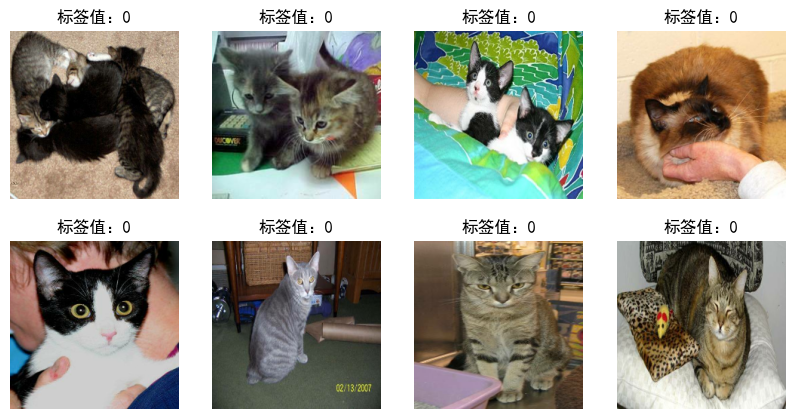

In [1]:
# 导入所需要的模块与包
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# 定义数据读取函数
def read_image_filenames(data_dir):
    cat_dir = os.path.join(data_dir, 'cat/')
    dog_dir = os.path.join(data_dir, 'dog/')
    
    # 构建特征数据集，值为对应的图片文件名
    cat_filenames = tf.constant([cat_dir + fn for fn in os.listdir(cat_dir)])
    dog_filenames = tf.constant([dog_dir + fn for fn in os.listdir(dog_dir)])
    filenames = tf.concat([cat_filenames, dog_filenames], axis=-1)
    
    # 构建标签数据集，cat 为 0，dog 为 1
    labels = tf.concat([tf.zeros(cat_filenames.shape, dtype=tf.int32),
                        tf.ones(dog_filenames.shape, dtype=tf.int32)], axis=-1)
    return filenames, labels

# 定义解码图片和调整图片大小的函数
def decode_image_and_resize(filename, label):
    # 读取原始文件
    image_string = tf.io.read_file(filename)
    
    # 解码 JPEG 图片
    image_decoded = tf.image.decode_jpeg(image_string)
    
    # 调整图像大小，要和模型输入要求一致，并进行标准化
    image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0
    return image_resized, label

# 定义准备数据集的函数
def prepare_dataset(data_dir, buffer_size=4000, batch_size=8):
    # 读取图片文件名和标签
    filenames, labels = read_image_filenames(data_dir)
    
    # 创建数据集
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(map_func=decode_image_and_resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # 打乱数据并批量化
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# 设置训练数据目录
data_dir = './train/'

# 准备训练数据集
dataset_train = prepare_dataset(data_dir)

# 将数据集转换为迭代器
it = iter(dataset_train)
images, labels = next(it)

# 显示部分样本的图像和标签
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为中文支持
plt.figure(figsize=(10, 5))  # 设置画布大小
for i in range(len(images)):
    plt.subplot(2, 4, i + 1)
    plt.title("标签值：" + str(labels.numpy()[i]))
    plt.imshow(images.numpy()[i])
    plt.axis("off")
plt.show()


## 3．构建基于 VGG16 的网络模型
猫狗大战网络模型是基于预训练好的 VGG16 网络模型进行构建的。VGG16 网络模型共有 16 层，即13 个卷积层和 3 个全连接层，不包括池化层和 Softmax 激活函数层。本项目中，冻结卷积基部分，添加分类器部分。新添加的分类器部分包括一个拉伸层、两个全连接层、两个 Dropout 层和一个输出层。由于数据集中有猫和狗两种图像，故应为输出层设置两个神经元，使用 Softmax 函数作为激活函数。  
步骤 1 定义构建网络模型的函数。加载预训练好的 VGG16 网络模型，不包括分类器，使用 ImageNet数据集预训练好的权重，并设置卷积基部分不可训练。  
步骤 2 使用函数式 API 模型构建网络模型。除预训练好的 VGG16 网络模型的卷积基部分外，依次添加拉伸层、包含 128 个神经元且使用 ReLU 函数作为激活函数的全连接层、丢弃概率为 0.3 的 Dropout层、包含 32 个神经元且使用 ReLU 函数作为激活函数的全连接层、丢弃概率为 0.3 的Dropout 层和包含两个神经元且使用 Softmax 函数作为激活函数的输出层。  
步骤 3 创建模型对象，并使用 summary()函数显示网络模型各层的参数信息。

In [2]:
# 构建基于 VGG16 的网络模型
def vgg16_model(input_shape=(224, 224, 3)):
    # 加载 VGG16 模型，选择不包含分类器部分
    vgg16 = tf.keras.applications.VGG16(
        include_top=False,  # 不包含顶层全连接分类器
        weights='imagenet',  # 使用 ImageNet 上的预训练权重
        input_shape=input_shape  # 输入图像形状
    )

    # 设置 VGG16 预训练模型不可训练
    for layer in vgg16.layers:
        layer.trainable = False

    # 获取 VGG16 的最后一层输出
    last = vgg16.output

    # 加入自定义全连接层
    x = tf.keras.layers.Flatten()(last)  # 展平层
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层1
    x = tf.keras.layers.Dropout(0.3)(x)  # Dropout 防止过拟合
    x = tf.keras.layers.Dense(32, activation='relu')(x)  # 全连接层2
    x = tf.keras.layers.Dropout(0.3)(x)  # 再次使用 Dropout
    x = tf.keras.layers.Dense(2, activation='softmax')(x)  # 输出层（2分类）

    # 构建模型
    model = tf.keras.models.Model(inputs=vgg16.input, outputs=x)
    return model

# 创建模型对象并测试
model = vgg16_model()  # 创建模型对象
model.summary()  # 显示网络模型各层的参数信息


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 4．编译和训练网络模型
步骤 1 编译网络模型。其中，损失函数使用稀疏交叉熵损失函数，优化器使用 Adam 优化器，性能评估函数使用准确率函数。  
步骤 2 训练网络模型。设置批量大小为 8，迭代次数为 5，日志显示模式为 1。

In [3]:
# 编译网络模型
model.compile(
    loss='sparse_categorical_crossentropy',  # 损失函数（适用于稀疏标签，如整数标签）
    optimizer='adam',  # 优化器，使用 Adam 进行梯度更新
    metrics=['accuracy']  # 评估指标：准确率
)

# 训练网络模型
history = model.fit(
    dataset_train,  # 训练数据集
    epochs=5,  # 训练轮数
    verbose=1  # 显示训练过程详细信息（1:详细信息，0:静默，2:每轮信息）
)


Epoch 1/5
3125/3125 [==============================] - 281s 87ms/step - loss: 0.1868 - accuracy: 0.9352
Epoch 2/5
3125/3125 [==============================] - 274s 87ms/step - loss: 0.1496 - accuracy: 0.9288
Epoch 3/5
3125/3125 [==============================] - 275s 87ms/step - loss: 0.1270 - accuracy: 0.9490
Epoch 4/5
3125/3125 [==============================] - 275s 88ms/step - loss: 0.1210 - accuracy: 0.9511
Epoch 5/5
3125/3125 [==============================] - 280s 89ms/step - loss: 0.1135 - accuracy: 0.9554


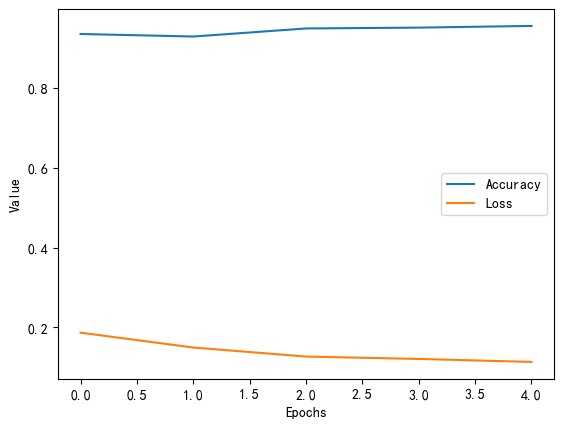

In [4]:
import matplotlib.pyplot as plt

# 绘制训练准确率和损失曲线
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


## 5．应用网络模型
步骤 1 定义读取测试集图像函数，函数参数为测试集文件夹的路径、读取图像开始位置、结束位置及图像的形状。① 获取测试数据集的文件列表；② 读取测试图像并转换为 NumPy 数组；③ 返回标准化处理后的测试图像数据。  
步骤 2 定义预测函数，函数参数为测试集文件夹的路径、读取图像开始位置、结束位置及图像的形状。① 读取测试图像并预处理；② 使用训练好的模型对测试数据进行预测；③ 显示图像及预测结果。  
步骤 3 调用预测函数，读取测试数据，使用训练好的模型进行预测，并显示预测结果。

1/1 [==============================] - 0s 187ms/step


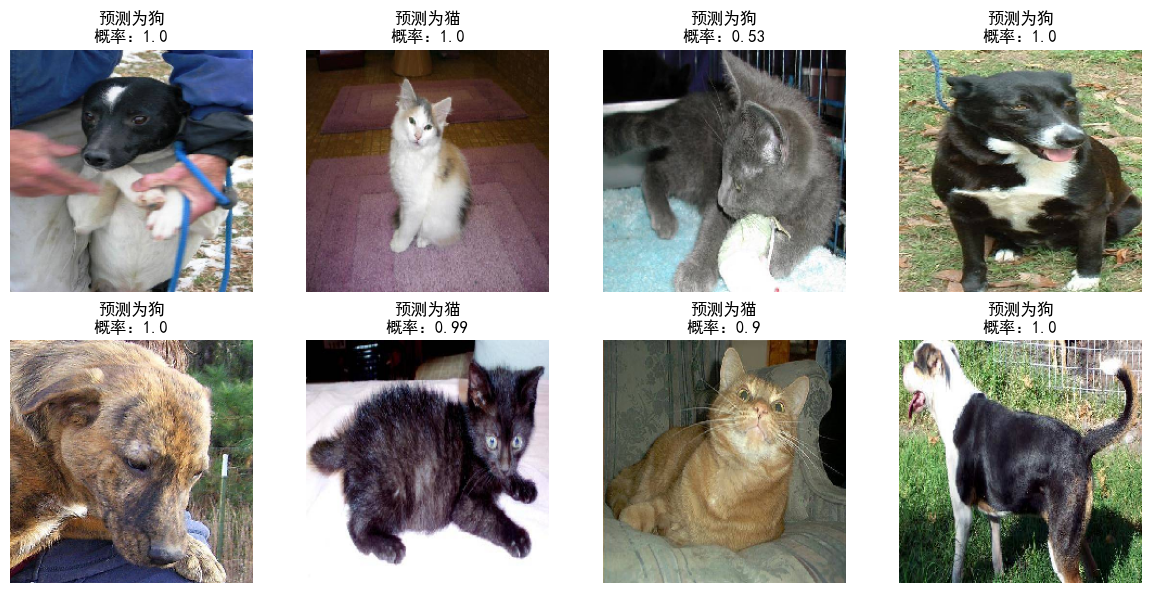

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# start 代表从第几张开始读取，finish 表示读到第几张为止
def read_image_files(path, start, finish, image_size=(224, 224)):
    test_files = os.listdir(path)
    test_images = []
    
    # 读取测试图片并进行预处理
    for fn in test_files[start:finish]:
        img_filename = os.path.join(path, fn)  # 构建完整文件路径
        img = tf.keras.preprocessing.image.load_img(img_filename, target_size=image_size)  # 加载图片
        img_array = tf.keras.preprocessing.image.img_to_array(img)  # 转换为数组
        test_images.append(img_array)
    
    # 转换为 NumPy 数组并进行标准化
    test_data = np.array(test_images)
    test_data /= 255.0  # 标准化到 [0, 1]
    return test_data

# 定义预测函数
def test_image_predict(path, start, finish, image_size=(224, 224)):
    # 读取测试图片并预处理
    test_data = read_image_files(path, start, finish, image_size)
    
    # 执行预测
    preds = model.predict(test_data)
    
    # 显示图片及预测结果
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
    plt.figure(figsize=(12, 6))  # 设置画布大小
    for i in range(0, finish - start):
        plt.subplot(2, 4, i + 1)  # 设置子图布局
        if np.argmax(preds[i]) == 0:
            label = "预测为猫\n概率：" + str(round(preds[i][0], 2))
        else:
            label = "预测为狗\n概率：" + str(round(preds[i][1], 2))
        plt.title(label)
        plt.imshow(test_data[i])  # 显示图片
        plt.axis('off')  # 隐藏坐标轴
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

# 从 test1 目录下读取测试数据并预测
test_data_dir = './test1/'
test_image_predict(test_data_dir, 0, 8)  # 预测 test1 文件夹中的前 8 张图片
